In [1]:
# modules
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

sys.path.append('../')
from baseModels.SVM.model import SVM
from ensemble.model import Ensemble

In [2]:
class TEClassification:
    
    def __init__(self,enzseqdata,labelfile,featurefiledirs,random_seed=None):
        
        self.random_seed = random_seed
        
        # original data based on which everything is obtained
        df1 = pd.read_csv(enzseqdata,header=None)
        df2 = pd.read_csv(label_file,header=None)
        self.df = df1.merge(df2,on=0)
        
        self.enz_names = self.df[0].values
        self.X = self.df.iloc[:,1].values
        self.y = self.df.iloc[:,-1].values
        
        # training and testing data for general use
        self.X_train, self.X_test, self.y_train, self.y_test,self.enz_train,self.enz_test = train_test_split(self.X, self.y,self.enz_names, test_size=0.25, random_state=self.random_seed)
        
        
        
        self.label_file = labelfile
        
        #generate a list of names from the directories
        featfiles = [d+f.name for d in featurefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        self.featnames = [f.name.replace('.csv.gz','') for d in featurefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        
        # getting all SVM objects together 
        self.objects = list(map(self.get_model_feat,featfiles))

        
        # select only the best models based on training
        self.best_idx,self.best_models = self.select_top_models(self.objects)
        self.best_model_names = np.array(self.featnames)[self.best_idx]
        
        # getting all model predictions together
        self.all_model_preds = [svmo.ypredtest for svmo in self.best_models]
        self.en = Ensemble(self.all_model_preds,self.y_test)
        self.precision = precision_score(self.y_test,self.en.preds,labels=[3],average='micro')
        
        pass
    
    
    def get_model_feat(self,featfilename):
        df1 = pd.read_csv(featfilename,header=None)
        df2 = pd.read_csv(self.label_file,header=None)
        df_feat = df1.merge(df2,on=0).set_index(0)
        df_feat_train = df_feat.loc[self.enz_train]
        df_feat_test = df_feat.loc[self.enz_test]
        X_train_feat,y_train_feat = df_feat_train.iloc[:,0:-1].values,df_feat_train.iloc[:,-1].values
        X_test_feat,y_test_feat = df_feat_test.iloc[:,0:-1].values,df_feat_test.iloc[:,-1].values

        if X_train_feat.shape[1]<40:
            n_comp = int(0.75*X_train_feat.shape[1])
        else:
            n_comp=40
            
        obj = SVM(X_train_feat,X_test_feat,y_train_feat,y_test_feat,verbose=False,optimize=False, pca_comp=n_comp,random_seed=self.random_seed,regC=30,kern='rbf')
        return obj
        
    def select_top_models(self,SVMOs):
        svm_train_accs = [svmo.acc_train for svmo in SVMOs]
        sorted_idx = np.argsort(svm_train_accs)[::-1]
        best_idx = sorted_idx[:27]
        return best_idx,np.array(SVMOs)[best_idx]
        

In [3]:
%%time
if __name__=='__main__':
    # Sequence and label files 
    enz_file = '../data/SeqFile/EnzymeSequence.csv'
    label_file = '../data/LabelFiles/EnzymeLabelsMultiClass.csv'

    # Feature dir for iFeature,kernel,pssm 
    ifeatdatadir = '../featEngg/ifeatMethods/data/featvec/'
    kerneldatadir = '../featEngg/kernelMethods/data/featvec/'
    pssmdatadir = '../featEngg/pssmMethods/data/featvec/'
    featdirs = [ifeatdatadir,kerneldatadir,pssmdatadir]


    te = TEClassification(enz_file,label_file,featdirs,random_seed=7)
    
    def multi_func(rs):
        te_i = TEClassification(enz_file,label_file,featdirs,random_seed=rs)
        return te_i.precision,te_i.en.acc    
    
    pool = mp.Pool(mp.cpu_count())

    
    
    
    metrics = list(pool.map(multi_func,range(10)))
    


CPU times: user 13.2 s, sys: 1.5 s, total: 14.7 s
Wall time: 31.5 s


In [4]:
te.en.acc

0.7586206896551724

In [5]:
te.precision

0.75

In [6]:
len(te.featnames)

45

In [7]:
prec = [metr[0] for metr in metrics]
accs = [metr[1] for metr in metrics]

In [8]:
print(min(prec),np.mean(prec),max(prec),np.std(prec))

0.6363636363636364 0.8141481067951656 0.9285714285714286 0.0732870337151135


In [9]:
print(min(accs),np.mean(accs),max(accs),np.std(accs))

0.6551724137931034 0.7620689655172412 0.8620689655172413 0.06254605912833466


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([1., 0., 0., 1., 0., 1., 4., 2., 0., 1.]),
 array([0.63636364, 0.66558442, 0.69480519, 0.72402597, 0.75324675,
        0.78246753, 0.81168831, 0.84090909, 0.87012987, 0.89935065,
        0.92857143]),
 <BarContainer object of 10 artists>)

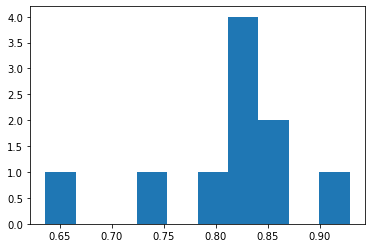

In [11]:
plt.hist(prec)

(array([1., 1., 0., 2., 0., 2., 1., 0., 2., 1.]),
 array([0.65517241, 0.67586207, 0.69655172, 0.71724138, 0.73793103,
        0.75862069, 0.77931034, 0.8       , 0.82068966, 0.84137931,
        0.86206897]),
 <BarContainer object of 10 artists>)

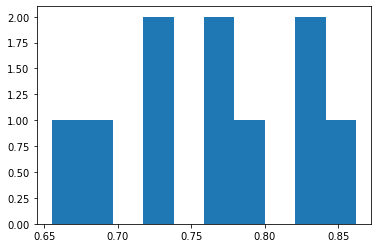

In [12]:
plt.hist(accs)